# Rating Prediction Project

## Problem statement :
Rating prediction is a well-known recommendation task aiming to predict a user’s rating for those items which were not rated yet by her. Predictions are computed from users’ explicit feedback, i.e. their ratings provided on some items in the past. Another type of feedback are user reviews provided on items which implicitly express users’ opinions on items. Recent studies indicate that opinions inferred from users’ reviews on items are strong predictors of user’s implicit feedback or even ratings and thus, should be utilized in computation. As far as we know, all the recent works on recommendation techniques utilizing opinions inferred from users’ reviews are either focused on the item recommendation task or use only the opinion information, completely leaving users’ ratings out of consideration. The approach proposed in this paper is filling this gap, providing a simple, personalized and scalable rating prediction framework utilizing both ratings provided by users and opinions inferred from their reviews.
	
   Experimental results provided on dataset containing user ratings and reviews from the real-world Amazon and Flipkart Product Review Data show the effectiveness of the proposed framework.


## Importing Libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing nltk libraries
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
import re
import pandas_profiling
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
lemmatizer = nltk.stem.WordNetLemmatizer()

## Data Loading

In [3]:
#loading the data into a dataframe
df = pd.read_csv("Rating.csv")
df

,Unnamed: 0,Review_title,Review_text,Ratings
0,0,Display as claimed FHD is not satifactory,\n &nbsp;I have purchased #LenovoIdeapad3<br>...,2.0 out of 5 stars
1,1,Display problem,\n &nbsp;Display problem..<br>i got delivered...,2.0 out of 5 stars
2,2,Received defective product,\n Received defective product (background noi...,2.0 out of 5 stars
3,3,No lenova product can T buy no support for ...,\n Product warranty is not support and batt...,2.0 out of 5 stars
4,4,Display quality is not good,"\n The display quality is not good, the rest ...",3.0 out of 5 stars
...,...,...,...,...
41977,41977,Paisa wasool Product,I am a developer and i need multiple screen fo...,5
41978,41978,Simply awesome,Amazingly super fast delivery!! Got it for a g...,5
41979,41979,Best in the market!,Nice Monitor. Curve is perfect for movies and ...,5
41980,41980,Highly recommended,Perfect for gaming. Has a good display when us...,5


### Feature Information:
* Review_title : title of the review
* Review_text : content of the review text
* Ratings : ratings out of 5 stars

At first I will drop the unwanted column Unnamed: 0

In [4]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [5]:
#checking the shape
print("Shape :", df.shape)

Shape : (41982, 3)


Great our data set is having 77550 rows and three columns now 

In [6]:
#checking column names
print("Columns :", df.columns)

Columns : Index(['Review_title', 'Review_text', 'Ratings'], dtype='object')


In [7]:
#data types
df.dtypes

Review_title    object
Review_text     object
Ratings         object
dtype: object

In [8]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  39728 non-null  object
 1   Review_text   39847 non-null  object
 2   Ratings       39728 non-null  object
dtypes: object(3)
memory usage: 984.1+ KB


By checking all above observations we can say the data contains three columns Review_title , Reiew_text and Ratings. All columns are object type.
Here Ratings column is our target column.

### Check for missing values

In [9]:
#missing values
df.isnull().sum()

Review_title    2254
Review_text     2135
Ratings         2254
dtype: int64

The data set is having lot of missing values and we will drop these values.

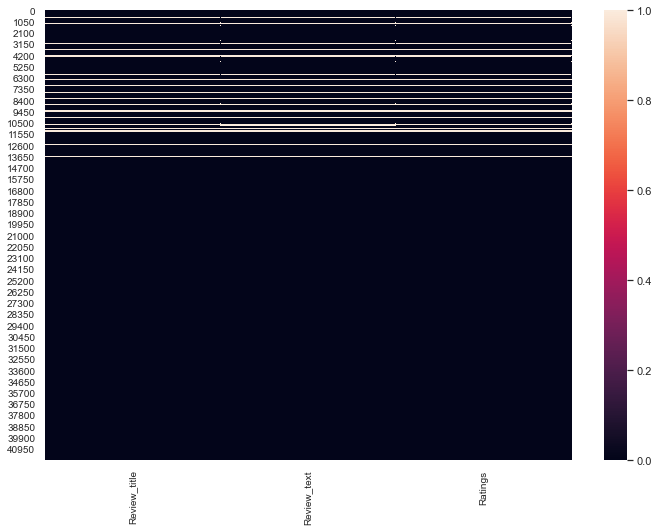

In [10]:
#Visualization of missing values
sns.set(rc={'figure.figsize':(11.8,8.27)})
sns.heatmap(data=df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [11]:
#Drop the rows where review_title and Reiew_text has null values
df.dropna(subset=['Review_title','Review_text'], inplace=True)

In [12]:
#checking for null values again
df.isnull().sum()

Review_title    0
Review_text     0
Ratings         0
dtype: int64

Great we have successfully removed all the missing data from our data set.

In [13]:
#lets check the shape of our data set now
df.shape

(39687, 3)

### Lets have a look at our target column

In [14]:
df['Ratings'].unique()

array(['2.0 out of 5 stars', '3.0 out of 5 stars', '1.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars', '5', '4', '3', '1',
       '2'], dtype=object)

Looking at these entries in target column we came to know that we need to replace the string entries to respective values(stars)

In [15]:
df['Ratings'] = df['Ratings'].replace('1.0 out of 5 stars',1)
df['Ratings'] = df['Ratings'].replace('2.0 out of 5 stars',2)
df['Ratings'] = df['Ratings'].replace('3.0 out of 5 stars',3)
df['Ratings'] = df['Ratings'].replace('4.0 out of 5 stars',4)
df['Ratings'] = df['Ratings'].replace('5.0 out of 5 stars',5)
df['Ratings'] = df['Ratings'].astype('int')

In [16]:
df['Ratings'].unique()

array([2, 3, 1, 5, 4])

## Combine Review_title and Reiew_text into one

In [17]:
#joining Review text and title
df['Review'] = df['Review_title'].map(str)+' '+df['Review_text']

In [18]:
#lets have a look at our data now
df

,Review_title,Review_text,Ratings,Review
0,Display as claimed FHD is not satifactory,\n &nbsp;I have purchased #LenovoIdeapad3<br>...,2,Display as claimed FHD is not satifactory \n ...
1,Display problem,\n &nbsp;Display problem..<br>i got delivered...,2,Display problem \n &nbsp;Display problem..<br...
2,Received defective product,\n Received defective product (background noi...,2,Received defective product \n Received defect...
3,No lenova product can T buy no support for ...,\n Product warranty is not support and batt...,2,No lenova product can T buy no support for ...
4,Display quality is not good,"\n The display quality is not good, the rest ...",3,Display quality is not good \n The display qu...
...,...,...,...,...
41977,Paisa wasool Product,I am a developer and i need multiple screen fo...,5,Paisa wasool Product I am a developer and i ne...
41978,Simply awesome,Amazingly super fast delivery!! Got it for a g...,5,Simply awesome Amazingly super fast delivery!!...
41979,Best in the market!,Nice Monitor. Curve is perfect for movies and ...,5,Best in the market! Nice Monitor. Curve is per...
41980,Highly recommended,Perfect for gaming. Has a good display when us...,5,Highly recommended Perfect for gaming. Has a g...


### Visualizing text in first three rows from Review column

In [19]:
df['Review'][0]

"Display as claimed FHD is not satifactory \n  &nbsp;I have purchased #LenovoIdeapad3<br>I am extremely disappointed to see its bad display quality. I can't see the screen clarity. It displays as white foggy and the viewing angle is very bad. I can see from a particular angle only. want to return #lenovoindia  Display as claimed FHD is not satisfactory. I am using Lenovo(T430, i5) which display is far better than this laptop. Need to return immediately\n"

In [20]:
df['Review'][1]

'Display problem \n  &nbsp;Display problem..<br>i got delivered on Aug 30th and opened it yesterday. Seen display problem. Return window closed two days back.. need support to rectify\n'

In [21]:
df['Review'][2]

'Received defective product \n  Received defective product (background noise when switching on the laptop) and no replacement was given by Amazon.\n'

## Text Processing

In [22]:
#Here I am defining a function to replace some of the contracted words to their full form and removing urls and some unwanted text 
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

In [23]:
#Lowercasing
df['Review'] = df['Review'].apply(lambda x : x.lower())

df['Review'] = df['Review'].apply(lambda x : decontracted(x))

#removing punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n',' ')


### lets have a look at our text again

In [24]:
df['Review'][0]

'display as claimed fhd is not satifactory    nbspi have purchased lenovoideapad3 i am extremely disappointed to see its bad display quality i can not see the screen clarity it displays as white foggy and the viewing angle is very bad i can see from a particular angle only want to return lenovoindia  display as claimed fhd is not satisfactory i am using lenovot430 i5 which display is far better than this laptop need to return immediately '

In [25]:
df['Review'][1]

'display problem    nbspdisplay problem i got delivered on aug 30th and opened it yesterday seen display problem return window closed two days back need support to rectify '

Great; we can clearly observe that we have successfully removed punctuations and unwanted text from our text and lowercased all our text

In [26]:
#Remove stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [27]:
df['Review'][0]

'display claimed fhd satifactory nbspi purchased lenovoideapad3 extremely disappointed see bad display quality see screen clarity displays white foggy viewing angle bad see particular angle want return lenovoindia display claimed fhd satisfactory using lenovot430 i5 display far better laptop need return immediately'

In [28]:
df['Review'][1]

'display problem nbspdisplay problem got delivered aug 30th opened yesterday seen display problem return window closed two days back need support rectify'

We can see that now we are having text without any stop words in it.

### Lemmatization

In [29]:
#Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [30]:
#defining function to lemmatize our text
def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)

In [31]:
df['Review'] = df['Review'].apply(lambda x : lemmatize_sentence(x))

In [32]:
df['Review'][0]

'display claim fhd satifactory nbspi purchase lenovoideapad3 extremely disappointed see bad display quality see screen clarity display white foggy view angle bad see particular angle want return lenovoindia display claim fhd satisfactory use lenovot430 i5 display far well laptop need return immediately'

In [33]:
df['Review'][1]

'display problem nbspdisplay problem get deliver aug 30th open yesterday see display problem return window close two day back need support rectify'

### Text Normalization - Standardization

In [34]:
#Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text

In [35]:
df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

In [36]:
df['Review'][0]

'display claim fhd satifactory nbspi purchase lenovoideapad extremely disappointed see bad display quality see screen clarity display white foggy view angle bad see particular angle want return lenovoindia display claim fhd satisfactory use lenovot i display far well laptop need return immediately'

In [37]:
df['Review'][1]

'display problem nbspdisplay problem get deliver aug th open yesterday see display problem return window close two day back need support rectify'

Finally I have defined a function scrub_words for removing the noise from the text. It will remove any html markups, digits and white spaces from the text. We can understand it by looking at first two row's text from review column

Now We have did all the text-processing steps and got required input for our model. We will go for EDA now

## Exploratory Data Analysis

In [38]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Word Counts

In [39]:
#creating column for word counts in the text
df['Review_WC'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WC','Review']].head()

,Review_WC,Review
0,42,display claim fhd satifactory nbspi purchase l...
1,22,display problem nbspdisplay problem get delive...
2,13,receive defective product receive defective pr...
3,12,lenova product buy support costumer service pr...
4,9,display quality good display quality good rest...


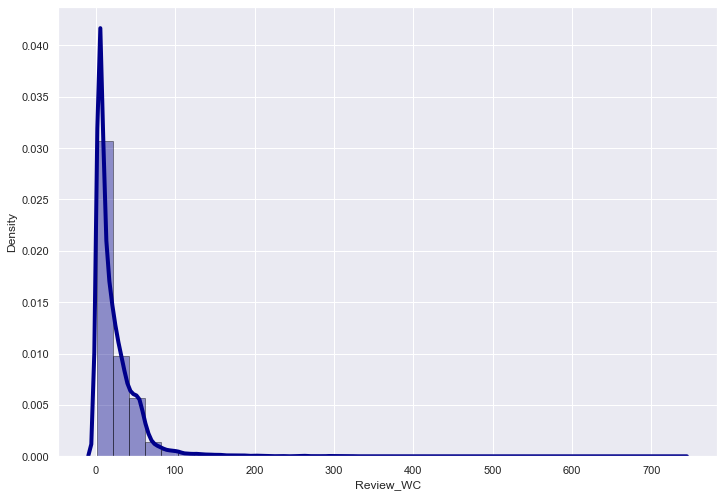

In [40]:
#density plot and histogram of all word count
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Looking at the above histogram we can clearly observe that most of our text is having the number of words in the range of 0 to 200, But some of the reviews are too lengthy which may act like outliers in our data. 

### Character count

In [41]:
#creating column for character counts in the text
df['Review_CC'] = df['Review'].str.len()
df[['Review_CC','Review']].head()

,Review_CC,Review
0,297,display claim fhd satifactory nbspi purchase l...
1,143,display problem nbspdisplay problem get delive...
2,106,receive defective product receive defective pr...
3,87,lenova product buy support costumer service pr...
4,57,display quality good display quality good rest...


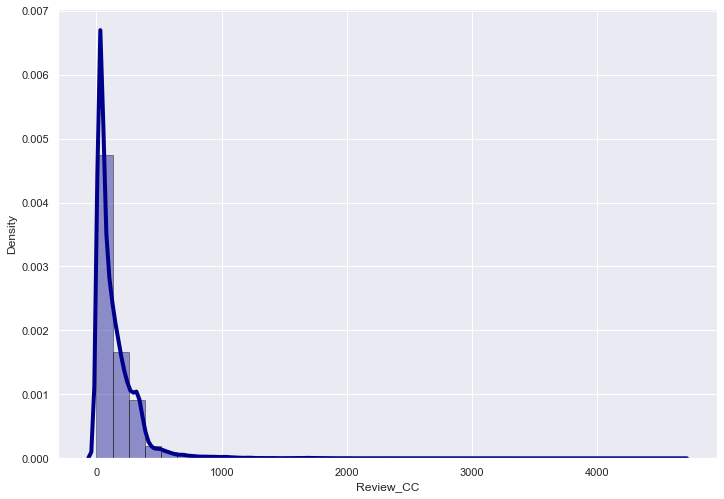

In [42]:
#density plot and histogram of all character count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Above plot represents histogram for character count of review text, which is quite similar to the histogram of word count.

### Removing Outliers

As we know that some of the review are too lengthy I am removing those reviews from the dats as outliers using z_score method.

In [43]:
#apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(39050, 6)

Great, by removing outliers we are loosing only arround 1000 entries which is acceptable here for getting beter results for our model.

### Plotting histograms for word count and character counts again after removing outliers

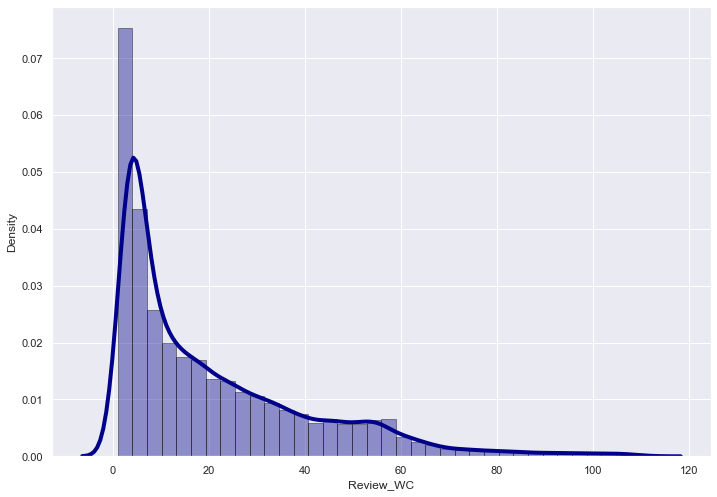

In [44]:
#density plot and histogram of all word count
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

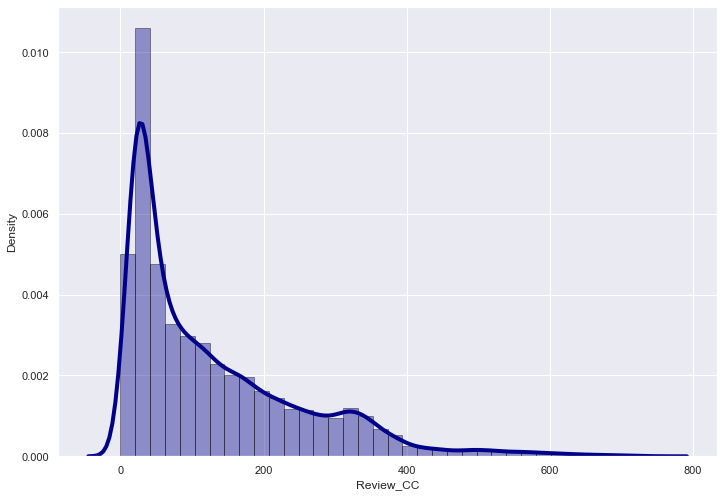

In [45]:
#density plot and histogram of all word count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

After plotting histograms for word counts and character counts after removing outliers we can see now we are with good range of number of words and characters

In [46]:
#lets have a look at our data set
df

,Review_title,Review_text,Ratings,Review,Review_WC,Review_CC
0,Display as claimed FHD is not satifactory,\n &nbsp;I have purchased #LenovoIdeapad3<br>...,2,display claim fhd satifactory nbspi purchase l...,42,297
1,Display problem,\n &nbsp;Display problem..<br>i got delivered...,2,display problem nbspdisplay problem get delive...,22,143
2,Received defective product,\n Received defective product (background noi...,2,receive defective product receive defective pr...,13,106
3,No lenova product can T buy no support for ...,\n Product warranty is not support and batt...,2,lenova product buy support costumer service pr...,12,87
4,Display quality is not good,"\n The display quality is not good, the rest ...",3,display quality good display quality good rest...,9,57
...,...,...,...,...,...,...
41977,Paisa wasool Product,I am a developer and i need multiple screen fo...,5,paisa wasool product developer need multiple s...,39,261
41978,Simply awesome,Amazingly super fast delivery!! Got it for a g...,5,simply awesome amazingly super fast delivery g...,25,172
41979,Best in the market!,Nice Monitor. Curve is perfect for movies and ...,5,best market nice monitor curve perfect movie g...,22,141
41980,Highly recommended,Perfect for gaming. Has a good display when us...,5,highly recommended perfect game good display u...,16,112


5    20281
4     7966
1     4491
3     3784
2     2528
Name: Ratings, dtype: int64


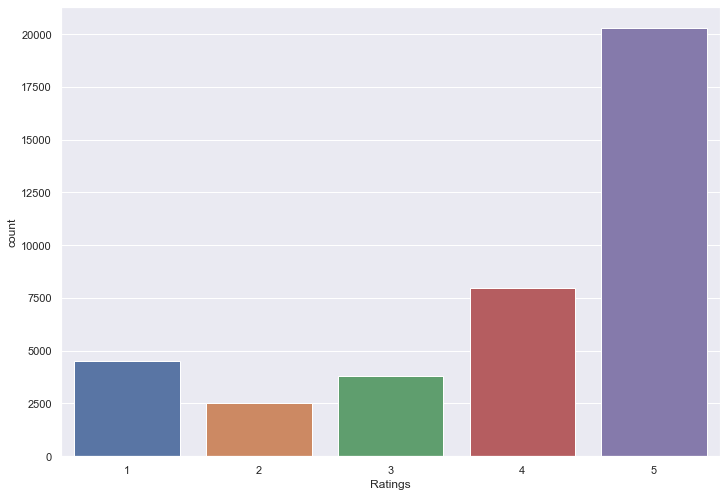

In [47]:
#Check the count of target column
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

* Looking at the above count plot for our target varible(Ratings) we can say that the data set is having most number of reviews rated as 5 star. and very less number of reviews rated as 2.
* Which will cause the __Imbalance problem__ for our model.
* So I am selecting equal number of reviews of each rating as a input for our model
* For that first I will shuffle the dataset so that we can select data from both web-sites
* Then I will select equal number of data of every category

In [48]:
#shuffling the data set
df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df

,Review_title,Review_text,Ratings,Review,Review_WC,Review_CC
0,Excellent,Nice Phone,5,excellent nice phone,3,20
1,Nice,Average monitor for this price...\nPros.\nGood...,3,nice average monitor price pro good panelits v...,59,366
2,Bad quality,"Bad valentine experience ,The fully charged ba...",2,bad quality bad valentine experience fully cha...,12,74
3,Decent product,\n Satisfied till now. Good quality. Comforta...,4,decent product satisfy till good quality comfo...,22,144
4,Excellent,Feeling happy thank you Flipkart and Gionee,5,excellent feel happy thank flipkart gionee,6,42
...,...,...,...,...,...,...
39045,Pretty good,best product ...!,4,pretty good best product,4,24
39046,Brilliant,Excellent Product..Far better than Apple watch...,5,brilliant excellent productfar well apple watch,6,47
39047,Battery charger very slow camara quality is ve...,\n Many dislike in this redmi 9 A camara qua...,2,battery charger slow camara quality low compar...,53,353
39048,Must buy!,Must buy,5,must buy must buy,4,17


In [50]:
#selct data from every category
df1 = df[df['Ratings']==1][0:7356]
df2 = df[df['Ratings']==2][0:7356]
df3 = df[df['Ratings']==3][0:7356]
df4 = df[df['Ratings']==4][0:7356]
df5 = df[df['Ratings']==5][0:7356]

In [51]:
#Combining all the dataframes into one and shuffling them 
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,Review_title,Review_text,Ratings,Review,Review_WC,Review_CC
0,Value-for-money,"This is actually a Good Watch. Well built, nic...",4,valueformoney actually good watch well build n...,12,82
1,Worst,\n It is a sample piece. I got the not for sa...,1,worst sample piece get sale productworst ever ...,15,90
2,Worth every penny,Very good product. Value for money. Battery ba...,5,worth every penny good product value money bat...,16,102
3,Great phone - but is region locked - cannot us...,\n The phone is good - except that it is NOT ...,1,great phone region lock can not use outside in...,60,361
4,Terrible product,Wrist products,1,terrible product wrist product,4,30
...,...,...,...,...,...,...
25510,Value-for-money,Nice. Not bad.,4,valueformoney nice bad,3,22
25511,Value-for-money,Nice product,4,valueformoney nice product,3,26
25512,Broke after 3 months and won’t return in warra...,\n Product broke after 3 months of usage.not ...,1,break month wont return warranty period produ...,47,302
25513,Value-for-money,Nice product. I got it for 2000 rs only .batte...,4,valueformoney nice product get r battery good...,37,229


4    7356
5    7356
1    4491
3    3784
2    2528
Name: Ratings, dtype: int64


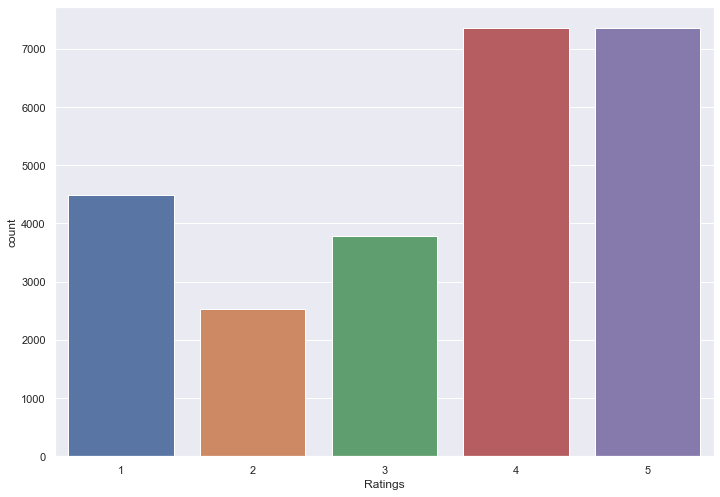

In [52]:
#lets Check the count of target column again
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

great, we have balanced our data.

### Top 30 most frequently occuring words

In [53]:
#function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

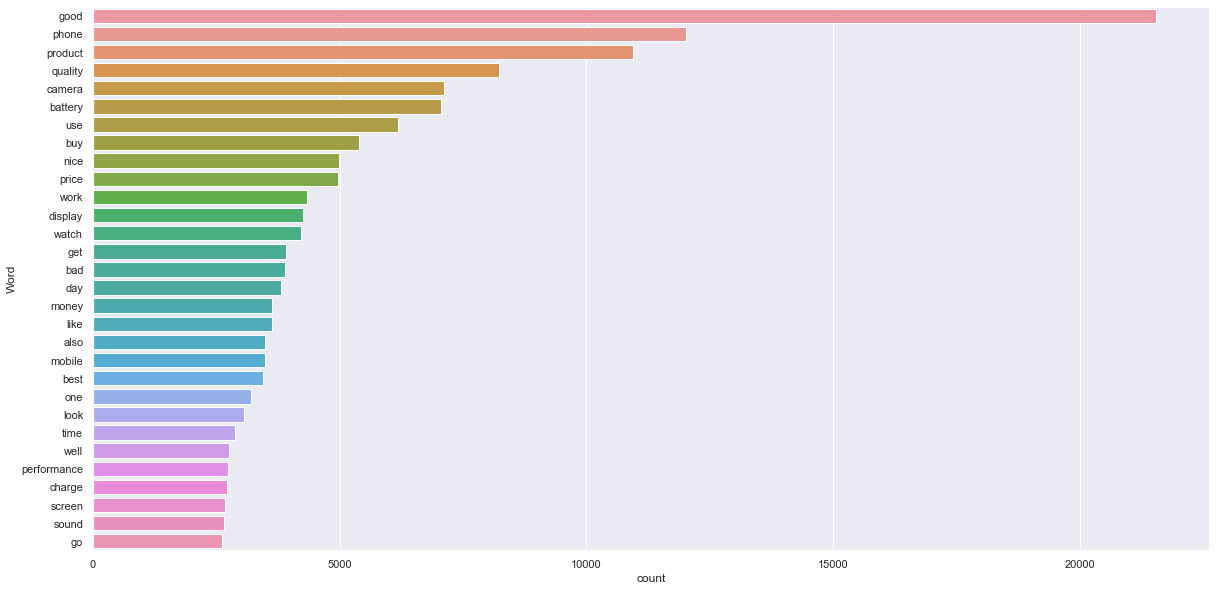

In [54]:
freq_words(df['Review'])

### Top 30 Rare words

In [55]:
#function to plot least frequent terms
def rare_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nsmallest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

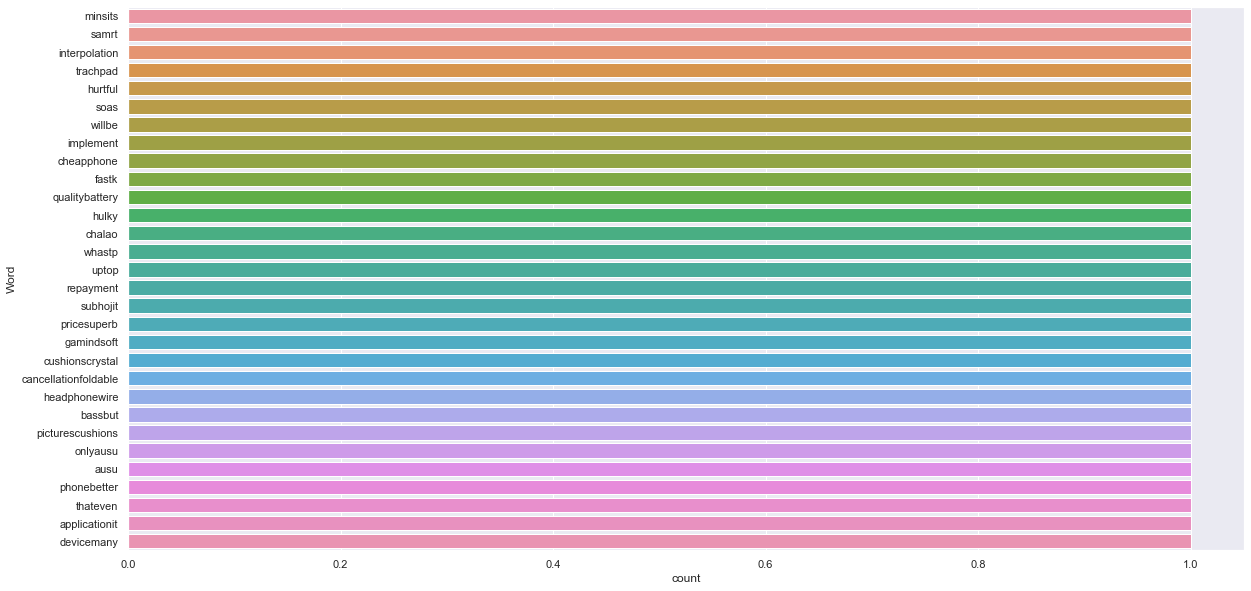

In [56]:
rare_words(df['Review'])

### Word cloud

In [57]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

### Words for rating = 1:

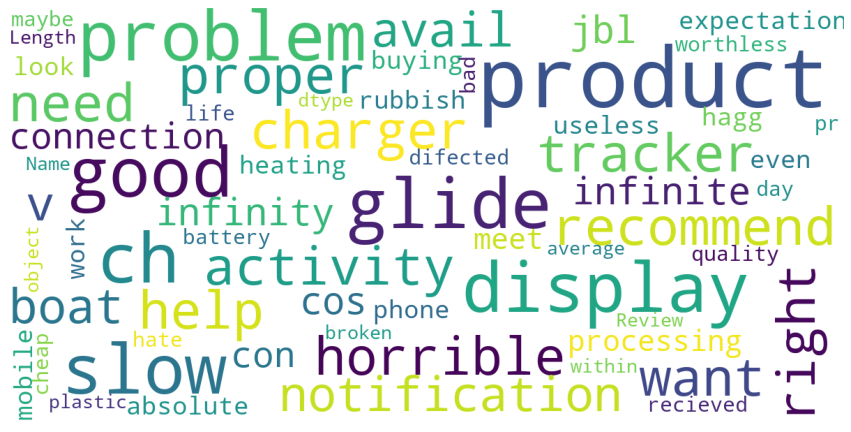

In [58]:
show_wordcloud(df1['Review'])

### Words for rating = 2:

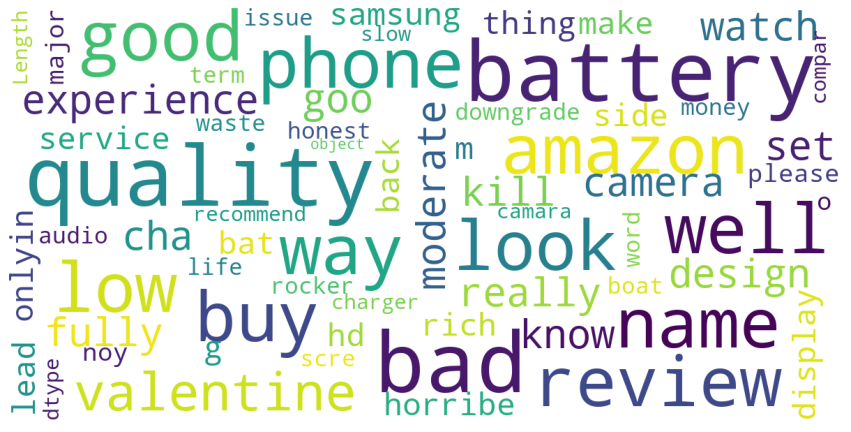

In [59]:
show_wordcloud(df2['Review'])

### Words for rating = 3:

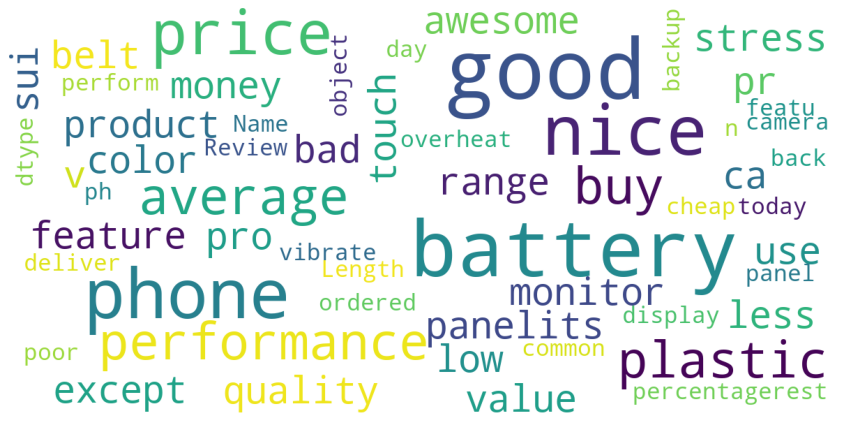

In [60]:
show_wordcloud(df3['Review'])

### Words for rating = 4:

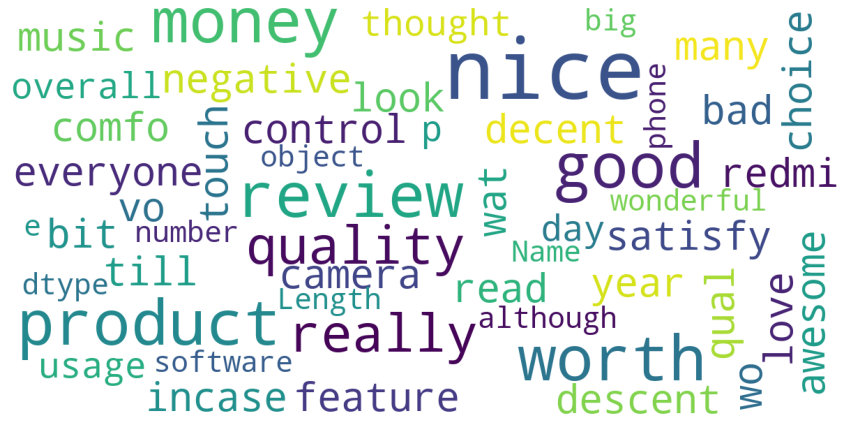

In [61]:
show_wordcloud(df4['Review'])

### Words for rating = 5:

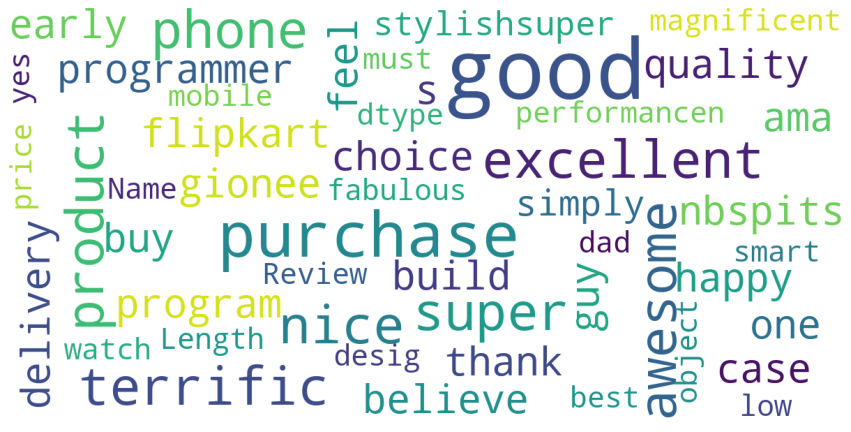

In [62]:
show_wordcloud(df5['Review'])

## Model Building and Evaluation

In [63]:
#separating features and labels
x = df['Review']
y = df['Ratings']

### Converting text into vectors using TfidfVectorizer

In [64]:
#using the n_gram tfidf vectorizer(Word vectors)
word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [65]:
#Character vectors
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

In [66]:
#I will combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features,train_word_features])

### Splitting the data into train and test

In [67]:
seed = 1
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = seed)

In [68]:
#lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (19136, 150000)
x_test (6379, 150000)
y_train (19136,)
y_test (6379,)


In [69]:
#defining the algorithms
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
xgb = XGBClassifier(verbosity=0)
bnb = BernoulliNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [70]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    accuracy = accuracy_score(y_test,pred)*100

    print(f"Accuracy Score:", accuracy)
    print("---------------------------------------------------")

    #confusion matrix & classification report
    
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")
    

### Training and testing of various algorithms

In [71]:
for model in [lr,svc,bnb,mnb,sgd,rf,xgb]:
    BuiltModel(model)

******************************LogisticRegression******************************
Accuracy Score: 86.56529236557454
---------------------------------------------------
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.84      0.91      0.87      1120
           2       0.79      0.64      0.71       628
           3       0.80      0.77      0.79       888
           4       0.85      0.91      0.88      1870
           5       0.95      0.92      0.93      1873

    accuracy                           0.87      6379
   macro avg       0.85      0.83      0.84      6379
weighted avg       0.87      0.87      0.86      6379

Confusion Matrix : 
 [[1014   43   39   18    6]
 [ 127  402   48   48    3]
 [  42   45  686  102   13]
 [  17   16   63 1702   72]
 [   9    3   17  126 1718]]

******************************LinearSVC******************************
Accuracy Score: 86.45555729738203
---------------------------------------------------
C

Great, among all these algorithms 4 are giving good accuracies: LogisticRegression, LinearSVC, SGDClassifier and RandomForestClassifier

### Cross validation score

In [72]:
def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score :", scores)

I am checking cross-validation score only for those algorithms which are giving us better accuracies

In [73]:
for model in [lr,svc,sgd,rf]:
    cross_val(model)

******************************LogisticRegression******************************
Cross validation score : 85.05193023711541
******************************LinearSVC******************************
Cross validation score : 85.25181265922006
******************************SGDClassifier******************************
Cross validation score : 85.24397413286303
******************************RandomForestClassifier******************************
Cross validation score : 84.58553791887125


Great all our algorithms are giving good cv scores with very less difference in accuracy and cv-scores. Among these algorithms I am selecting LinearSVC as best suitable algorithm for our final model as it is giving least difference in accuracy and cv score with higher accuracy.

## HyperParameter Tuning

In [74]:
#lets selects different parameters for tuning
grid_params = {
                'penalty':['l2'],
                'loss':['hinge','squared_hinge'],
                'multi_class': ['ovr'],
                'intercept_scaling':[2,3],
                'dual':[True,False],
                }

In [75]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(svc, grid_params, cv = 3, verbose=10)
GCV.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 1/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  19.6s
[CV 2/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 2/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  29.0s
[CV 3/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 3/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  25.2s
[CV 1/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 1/3; 2/8] END dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2; total time=  13.4s
[CV 2/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 2/3; 2/8] EN

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'dual': [True, False], 'intercept_scaling': [2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2']},
             verbose=10)

In [76]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'dual': True,
 'intercept_scaling': 3,
 'loss': 'hinge',
 'multi_class': 'ovr',
 'penalty': 'l2'}

## Final Model

In [77]:
#training and testing our final model with above parameters
model = LinearSVC(dual = True, intercept_scaling = 2, loss = 'hinge', multi_class = 'ovr', penalty = 'l2')
model.fit(x_train,y_train) #fitting data to model
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)*100

#printing accuracy score
print("Accuracy Score :", accuracy)

#printing Confusion matrix
print(f"\nConfusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

#printing Classification report
print(f"\nCLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

Accuracy Score : 86.56529236557454

Confusion Matrix : 
 [[1004   56   37   18    5]
 [ 123  413   42   42    8]
 [  37   46  694   95   16]
 [  20   20   60 1679   91]
 [   9    5   17  110 1732]]


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.84      0.90      0.87      1120
           2       0.76      0.66      0.71       628
           3       0.82      0.78      0.80       888
           4       0.86      0.90      0.88      1870
           5       0.94      0.92      0.93      1873

    accuracy                           0.87      6379
   macro avg       0.84      0.83      0.84      6379
weighted avg       0.86      0.87      0.86      6379



Great; after doing hyperparameter tuning we have got improved accuracy score for our final model.

## Model Saving

In [78]:
import joblib
joblib.dump(model,"Rating_Prediction.pkl")

['Rating_Prediction.pkl']

Finally I am saving this model into a .pkl file

### Conclusion:
__Key findings of the study :__

In this project I have collected data of reviews and ratings for different products from amazon.in and flipkart.com. Then I have done different text processing for reviews column and chose equal number of text from each rating class to eliminate problem of imbalance. By doing different EDA steps I have analyzed the text. We have checked frequently occurring words in our data as well as rarely occurring words. After all these steps I have built function to train and test different algorithms and using various evaluation metrics I have selected LinearSVC for our final model. 
Finally by doing hyperparameter tuning we got optimum parameters for our final model. And finally we got improved accuracy score for our final model.

__Limitations of this work and scope for the future work :__

As we know the content of text in reviews is totally depends on the reviewer and they may rate differently which is totally depends on that particular person. So it is difficult to predict ratings based on the reviews with higher accuracies.
Still we can improve our accuracy by fetching more data and by doing extensive hyperparameter tuning.
